In [12]:
from scipy import interpolate
from scipy.interpolate import griddata
from scipy.interpolate import RBFInterpolator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import datetime as dt

from time import sleep
from matplotlib import animation
from matplotlib.animation import ArtistAnimation

#from matplotlib.mlab import griddata

In [13]:
#Read in tower coords and set up dataframe
tc = pd.read_csv('../Misc_data/tower_coords.csv') #dataframe of tower coordinates
tc.set_index('Tower', inplace = True)

#Convert lat and lon to coordinates in km, origin currently set to PFA coordinates, should change this since PFk is out of range
tc['x'] = (tc.Lon - tc.Lon['PFA'])*111*np.cos(tc.Lat['PFA']*np.pi/180)
tc['y'] = (tc.Lat - tc.Lat['PFA'])*111 

In [14]:
#Constants
R = 8.314 #kgm^2s^-2K^-1mol^-1
h = 30 #Measurement height in m
L = 2.5*10**3 #Latent heat of vapoization of water at 0 deg C [J/g], should try to calc based on dependency on C
cp = 1005 #J/kg*K
mm = 0.02896 #kg/mol molar mass dry air
mm_w = 18.01 # molar mass of water [g/mol]
CtoK = 273.15 #Conversion from Celcius to Kelvin



In [15]:
# Start dataframes with PFA tower 
# Same as used above except sections marked as not in use


#Import data
filepath = '../Misc_data/US-PFa_HR_201901010000_202001010000.csv' #This is hourly data -> need halfhourly to match up with other towers
PFA = pd.read_csv(filepath)

PFA = PFA.applymap(lambda x: np.nan if x == -9999 else x)

#Add datetime index
dt_ts = pd.to_datetime(PFA['TIMESTAMP_START'], format = '%Y%m%d%H%M') + dt.timedelta(minutes = 30) #half hour time stamp
PFA.set_index(dt_ts, inplace = True)


#Linear interpolate PFA data to 15 min and then use just min 15 and 45 timestamps
PFA_interp = PFA.resample('15T').mean().interpolate()
PFA_interp = PFA_interp[(PFA_interp.index.minute == 15) | (PFA_interp.index.minute == 45)]

#Cut to fit dates for the rest of the Cheesehead sites
startdate = dt.datetime(2019, 6, 20)
enddate = dt.datetime(2019, 10, 14)
PFA_interp = PFA_interp[startdate: enddate]

#Create dataframe with TA in K
df_TA_K = pd.DataFrame(PFA_interp.TA_1_3_1).rename(columns = {'TA_1_3_1':'PFA'}) + CtoK #Air temp[K]



#Calc H2O concenctration in g/m^3
es_PFA = 611.2*np.exp((17.67*PFA_interp.TA_1_3_1)/(PFA_interp.TA_1_3_1+ 243.5)) #Saturation vapor pressure [Pa] - Petty eqn 7.19 (pg 183)
e_PFA = es_PFA*PFA_interp.RH_1_3_1.values.flatten()/100 #Vapor pressure [Pa]
H2O_RH = np.asarray(e_PFA)[:, None]/(R*(df_TA_K))*mm_w #Water vapor concentration, calculated from RH [g/m^3]
df_H2O = pd.DataFrame(H2O_RH).rename(columns = {0:'PFA'}) #Water vapor concentration[g/m^3]

#Other Energy balance terms
df_Rad = pd.DataFrame(PFA_interp.TA_1_3_1).rename(columns = {'TA_1_3_1':'PFA'})

# #Calc H2O concentration form H2O column in PFA - get different results from above, not sure why
# PA_Pa = PFA_interp.PA_1_1_1*1000 #kPa to Pa
# md_a = PA_Pa/(R*TA_K) #Molar density of air [mol/m^3]
# df_H2O = pd.DataFrame(PFA_interp.H2O_1_3_1*md_a*mm_w/1000).rename(columns = {0:'PFA'}) #Water vapor concentration[g/m^3]

# #No gap-filled wind dir and speed data, for now use PFA data, 
#later use WD and WS from individual towers unless missing, then use PFA
SN_wind = -np.asarray(PFA_interp.WS_1_3_1*np.sin(PFA_interp.WD_1_3_1*np.pi/180))[:, None].T
WE_wind = -np.asarray(PFA_interp.WS_1_3_1*np.cos(PFA_interp.WD_1_3_1*np.pi/180))[:, None].T


for i in tc.index:

    if i == 'PFA':
        pass
    elif i == 'PFr': #No gap filled data for PFr
        df_TA_K[i] = np.nan
        df_H2O[i] = np.nan
    else: 
        print(i)
        filepath = tc['gf_path'][i] #'http://co2.aos.wisc.edu/data/CHEESEHEAD-incoming/Ameriflux/US-' + i + '_HH_201906010000_201911010000.csv'
        data = pd.read_csv(filepath, sep = '\t', header = [0,1])
        
        #Add data for each tower
        df_TA_K[i] = data.Tair_f.values + CtoK #Temperature [K]
     
        
        
        es = 611.2*np.exp(17.67*(df_TA_K[i]-CtoK)/(df_TA_K[i])) #Saturation vapor pressure [Pa] - Petty eqn 7.19 (pg 183)
        e = es*data.rH_f.values.flatten()/100 #Vapor pressure [Pa]
        df_H2O[i] = e/df_TA_K[i]/R*mm_w #Water vapor concentration [g/m^3]
        
     
        
        
        #This code does not force the timestamps to line up, might be better to make a timestamp out of the 'Date Time' 
        #column to ensure, since right now that is just done manually by cutting the PFA data to start and end at the 
        #same time as the others
        # data['ts_mid'] = pd.to_datetime(data['Date Time'], format = '%Y-%m-%d %H:%M:%s') -dt.timedelta(minutes = 15)
        #data.set_index('dt_ts', inplace = True)
        #df_T.merge(pd.DataFrame(data.TA_1_1_1).rename(columns = {'TA_1_1_1':i}))

PFb
PFc
PFd
PFe
PFg
PFh
PFi
PFj
PFk
PFl
PFm
PFn
PFp
PFq
PFs
PFt


In [18]:
df_H2O

,PFA,PFb,PFc,PFd,PFe,PFg,PFh,PFi,PFj,PFk,PFl,PFm,PFn,PFp,PFq,PFr,PFs,PFt
TIMESTAMP_START,,,,,,,,,,,,,,,,,,
2019-06-20 00:15:00,7.310890,10.868054,8.261174,7.183555,7.449843,7.166941,12.466397,7.537173,9.961047,12.442558,7.278623,6.737326,6.858504,7.007826,10.556673,NaN,8.640714,7.584457
2019-06-20 00:45:00,7.376068,10.787904,8.114503,7.037627,7.729686,7.142002,12.430741,7.366342,10.036984,12.432202,7.231525,6.827918,6.920936,6.993112,10.485936,NaN,8.634126,7.623380
2019-06-20 01:15:00,7.458848,10.717136,7.931133,6.908301,8.086716,7.144066,12.367157,7.307185,10.133510,12.416062,7.204146,6.909479,7.020943,6.977784,10.407502,NaN,8.574048,7.731678
2019-06-20 01:45:00,7.478643,10.621295,7.702863,6.774606,8.003402,7.000284,12.282414,7.238131,10.218815,12.377886,7.187818,6.976252,7.033366,6.960746,10.314641,NaN,8.493571,7.782814
2019-06-20 02:15:00,7.438913,10.484783,7.490381,6.629581,7.951937,6.854223,12.206421,7.209058,10.299142,12.309882,7.160712,6.974408,6.995886,6.967342,10.223877,NaN,8.387699,7.752243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-13 21:45:00,4.886409,3.899074,5.198024,5.038899,3.994479,4.077024,4.057892,3.951973,3.928953,4.954856,4.029528,4.127202,4.008991,3.902322,3.853251,NaN,3.953606,3.827322
2019-10-13 22:15:00,4.874901,3.842678,5.190900,5.031059,3.932330,4.019310,3.973593,3.877243,3.847933,4.943014,3.957173,4.035094,4.105444,3.821661,3.759840,NaN,3.862294,3.737101
2019-10-13 22:45:00,4.863051,3.755258,5.183810,5.028441,3.840378,3.920081,3.870492,3.771370,3.734266,4.901661,3.856505,3.925771,7.077200,3.712070,3.656007,NaN,3.759584,3.637311


In [10]:
#N, S, E, W coords (in km)
tc['y_N'] = tc['y'] + 1
tc['y_S'] = tc['y'] - 1
tc['x_E'] = tc['x'] + 1
tc['x_W'] = tc['x'] - 1

#Make a 2D array with x and y values for location of each tower
ar = np.array([tc.y.values, tc.x.values]).T

#3D arrays of locations 1km up and down wind of each tower 
#Dims are tower, time, and direction (x/y)
N_coords = np.stack((tc.x.values, tc.y_N.values)).T
S_coords = np.stack((tc.x.values, tc.y_S.values)).T
E_coords = np.stack((tc.x_E.values, tc.y.values)).T
W_coords = np.stack((tc.x_W.values, tc.y.values)).T


#Interpolate to N, S, E, W points
T_i_N = RBFInterpolator(ar, df_TA_K.values.T)(N_coords)
T_i_S = RBFInterpolator(ar, df_TA_K.values.T)(S_coords)
T_i_E = RBFInterpolator(ar, df_TA_K.values.T)(E_coords)
T_i_W = RBFInterpolator(ar, df_TA_K.values.T)(W_coords)

H2O_i_N = RBFInterpolator(ar, df_H2O.values.T)(N_coords)
H2O_i_S = RBFInterpolator(ar, df_H2O.values.T)(S_coords)
H2O_i_E = RBFInterpolator(ar, df_H2O.values.T)(E_coords)
H2O_i_W = RBFInterpolator(ar, df_H2O.values.T)(W_coords)


In [231]:
#H and LE advection calcs

PA_Pa = PFA_interp.PA_1_1_1*1000 #kPa to Pa **this is at top of tower(~400m), need PA val for 30m and below**
rho = mm*PA_Pa/df_TA_K.T/R #Dry air density at each tower [kg/m^3] **should probably use virtual temperature here** 
z = np.asarray(tc.z)[:, None] #Height of each tower


#H advection
H_SN = rho*z*cp*SN_wind*(T_i_S - T_i_N)/2000 #Advection of sensible heat by southerly wind [W/m^2]
H_WE = rho*z*cp*WE_wind*(T_i_W - T_i_E)/2000 #Advection of sensible heat by westerly wind [W/m^2]
H_ad = H_SN + H_WE #Total advection

#LE advection
LE_SN = z*L*SN_wind*(H2O_i_S - H2O_i_N)/2000 #Advection of latend heat by southerly wind [W/m^2]
LE_WE = z*L*WE_wind*(H2O_i_W - H2O_i_E)/2000 #Advection of latent hear by westerly wind [W/m^2]

LE_ad = (LE_SN + LE_WE)*rho/rho #LE advection (the *rho/rho just makes it a df with the same tower and timestamp as indices)


hrz_ad = (H_ad + LE_ad).T
#Deal with water vapor later
# md_w = e/(R*TA_K) #Molar density of water vapor [mol/m^3], used in SLE calc


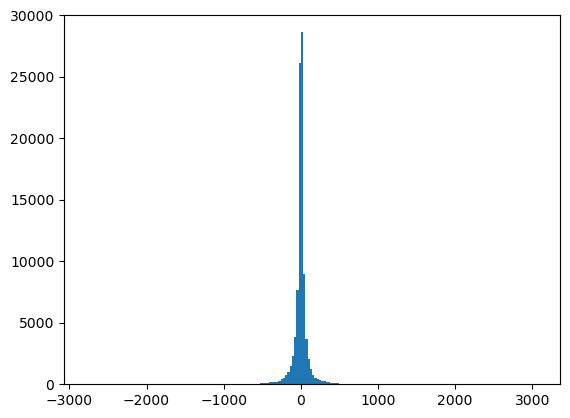

In [245]:
ad_day = hrz_ad.groupby(hrz_ad.index.date).mean()

# for tower in tc.index:
#     plt.plot(ad_day[tower])
    
# plt.xticks(rotation = 45);

hrz_ad_flat = np.asarray(hrz_ad).flatten()
plt.hist(hrz_ad_flat, bins = 200);

In [247]:
ad_day.mean().mean()

-0.9472611038323914

## Code Graveyard

In [ ]:
#Reading in an formatting PFA data

# filepath = '../Misc_data/US-PFa_HR_201901010000_202001010000.csv'
# df = pd.read_csv(filepath)

# startdate = dt.datetime(2019, 6, 1)
# enddate = dt.datetime(2019, 10, 31)

# df['dt_ts'] = pd.to_datetime(df['TIMESTAMP_START'], format = '%Y%m%d%H%M')
# df.set_index('dt_ts', inplace = True)
# df = df.applymap(lambda x: np.nan if x == -9999 else x)
# df

In [ ]:
##Interpolation using scipy.interpolate.griddata (does not extrapolate)
# x_grid = np.linspace(-6, 4, 101)
# y_grid = np.linspace(-5, 5, 101)
# X, Y = np.meshgrid(x_grid, y_grid)

# T_i_g = griddata((tc.x, tc.y), tc.T1, (X, Y), method = 'linear')

In [ ]:
##Test grid with artificial data
# test_dic = {'x':[-4, 4, 4, -4, 0], 'y': [-5, 4, -4, 4, 0], 'T1': [5, -5, 10, -10, 0]}
# tc = pd.DataFrame.from_dict(test_dic)


# tar = np.array([td.x.values, td.y.values]).T

# T_i_g = griddata((td.x, td.y), td.vals, (X, Y), method = 'linear')
# T_i_r = RBFInterpolator(tar, td.vals.values)(xflat).reshape(101, 101)

# fig, axs = plt.subplots(1, 2, figsize = (10, 5))
# plt.figure(figsize=(4, 3))
# axs[0].pcolormesh(x_grid, y_grid, T_i_g)
# #axs[0].colorbar()
# plt.figure(figsize=(4, 3))
# axs[1].pcolormesh(x_grid, y_grid, T_i_r)
# #plt.colorbar()

In [ ]:
##Tower coords as a dictionary, covert to a Pandas dataframe
# tower_coords = {'PFA': [45.9459, -90.2723],
#                 'PFb': [45.972,	-90.3232],
#                 'PFc': [45.9677, -90.3088],
#                 'PFd': [45.9689, -90.301], 
#                 'PFe': [45.9793, -90.3004],
#                 'PFg': [45.9735, -90.2723],
#                 'PFh': [45.9557, -90.2406],
#                 'PFi': [45.9749, -90.2327],
#                 'PFj': [45.9619, -90.227],
#                 'PFk': [45.9149, -90.3425], 
#                 'PFl': [45.9409, -90.3177],
#                 'PFm': [45.9207, -90.3099],
#                 'PFn': [45.9392, -90.2823],
#                 'PFp': [45.9365, -90.2641],
#                 'PFq': [45.9271, -90.2475],
#                 'PFr': [45.9245, -90.2475],
#                 'PFs': [45.9381, -90.2382],
#                 'PFt': [45.9197, -90.2288]}


# tc = pd.DataFrame.from_dict(tower_coords, orient ='index') 
# tc.columns = ['Lat', 'Lon']


In [ ]:
## Plot tower locations
# plt.figure(figsize=(5,5))
# plt.scatter(tc.x, tc.y)

# plt.xlim(-6, 5);
# plt.ylim(-5, 5);

In [ ]:
# #Calc up and downwind coords

# filepath = '../Misc_data/US-PFa_HR_201901010000_202001010000.csv'
# df = pd.read_csv(filepath).applymap(lambda x: np.nan if x == -9999 else x)
# #plt.plot(df.WD_1_1_1)
# x_up = np.cos(df.WD_1_1_1*np.pi/180)
# y_up = np.sin(df.WD_1_1_1*np.pi/180)
# x_down = -np.cos(df.WD_1_1_1*np.pi/180)
# y_down = -np.sin(df.WD_1_1_1*np.pi/180)

In [ ]:
# #PFo data
# df_PFo = pd.read_csv('../Misc_data/Missing_sites/AMF_US-PFo_BASE-BADM_1-5/AMF_US-PFo_BASE_HH_1-5.csv', header = 2)
# df_PFo

In [ ]:
##When I was putting all the data in the tc dataframe
# tc['T1'] = 0 #Create T1 column
# idx = 2342

# for i in tc.index:
#     if i == 'PFA':
#         filepath = '../Misc_data/US-PFa_HR_201901010000_202001010000.csv'
#         df = pd.read_csv(filepath)

#         startdate = dt.datetime(2019, 6, 1)
#         enddate = dt.datetime(2019, 10, 31)

#         df['dt_ts'] = pd.to_datetime(df['TIMESTAMP_START'], format = '%Y%m%d%H%M')
#         df.set_index('dt_ts', inplace = True)
        
#         T1 = df.TA_1_1_1[idx]
        
#         T1 = np.nan
#     else:
#         filepath = 'http://co2.aos.wisc.edu/data/CHEESEHEAD-incoming/Ameriflux/US-' + i + '_HH_201906010000_201911010000.csv'
#         df = pd.read_csv(filepath)
#         T1 = df.TA_1_1_1[idx]
#     #tc.T1[i] = T1 
#     tc.loc[tc.index == i, 'T1'] = T1 #Gives the same output as line above but doesn't generate warning
#     tc = tc.applymap(lambda x: np.nan if x == -9999 else x)
    
# tc.dropna(inplace = True)

In [53]:
# #Compare reddyproc gapfilled to original data
# df_rgf = pd.read_csv('../Gap_filling/PFb_gap_filled.txt', sep = '\t', header = [0,1])
# # df_rgf['dt_ts'] = pd.to_datetime(df_rgf['TIMESTAMP_START'], format = '%Y%m%d%H%M')
# df_rgf = df_rgf.applymap(lambda x: np.nan if x == -9999 else x)


# df_orig = pd.read_csv('http://co2.aos.wisc.edu/data/CHEESEHEAD-incoming/Ameriflux/US-PFb_HH_201906010000_201911010000.csv')
# df_orig['dt_ts'] = pd.to_datetime(df_orig['TIMESTAMP_START'], format = '%Y%m%d%H%M')
# df_orig = df_orig.applymap(lambda x: np.nan if x == -9999 else x)


# df_ogf = pd.read_csv('http://co2.aos.wisc.edu/data/CHEESEHEAD-incoming/gapfilled/REddyProc_v2/REddyResults_US-PFb_20210715_686681864/output.txt', sep = '\t', header = [0,1])
# # df_rgf['dt_ts'] = pd.to_datetime(df_rgf['TIMESTAMP_START'], format = '%Y%m%d%H%M')
# df_ogf = df_ogf.applymap(lambda x: np.nan if x == -9999 else x)



# # diff = df_orig.FC_1_1_1 - df_rgf.NEE_ORIG
# # df_orig.FC_1_1_1.count(), df_rgf.NEE_ORIG.count()
# # plt.plot(df_rgf.dt_ts, diff)
# # plt.xticks(rotation = 45);

# df_orig.H_1_1_1.count()
# df_ogf.NEE_uStar_orig.count(), df_ogf.NEE_uStar_f.count()



# # diff = df_orig.NEE_1_1_1 - df_rgf.NEE_orig
# # plt.plot(diff)

# start = 2700
# end = 2800

# diff = df_rgf.NEE_f.values[:,0] - df_orig.NEE_1_1_1
# plt.plot(df_rgf.NEE_f.values[:,0][start:end])
# plt.plot(df_orig.NEE_1_1_1[start:end].values)
# plt.plot(diff[start:end].values)

# #plt.plot(df_rgf.NEE_f)

# # df_rgf.NEE_f.shape, df_orig.NEE_1_1_1.shape
# # df_rgf.NEE_f.values[:,0].shape, df_orig.NEE_1_1_1.values.shape

In [ ]:
# #Start dataframes with PFA tower 
# #Same as used above except sections marked as not in use

# #Import data
# filepath = '../Misc_data/US-PFa_HR_201901010000_202001010000.csv' #This is hourly data -> need halfhourly to match up with other towers
# PFA = pd.read_csv(filepath)

# PFA = PFA.applymap(lambda x: np.nan if x == -9999 else x)

# #Add datetime index
# dt_ts = pd.to_datetime(PFA['TIMESTAMP_START'], format = '%Y%m%d%H%M') + dt.timedelta(minutes = 30) #half hour time stamp
# PFA.set_index(dt_ts, inplace = True)

# #Time series at 15 and 45 min timestampes -- didn't end up using
# ts_30 = pd.to_datetime(PFA['TIMESTAMP_START'], format = '%Y%m%d%H%M') + dt.timedelta(minutes = 30) #half hour time stamp
# ts_15 = ts_30 - dt.timedelta(minutes = 15) #Time stamps on min 15 of every hour
# ts_45 = ts_30 + dt.timedelta(minutes = 15) #Timestamps on min 45 of every hours
# ts_hh = pd.concat([ts_15, ts_45]).sort_values() #Time stamps on mins 15 and 45 (center of each 30 min time step)

# #Linear interpolate to 15 min and then use just min 15 and 45 timestamps
# T_interp = PFA.TA_1_1_1.resample('15T').mean()
# T_interp = T_interp.interpolate()[(T_interp.index.minute == 15) | (T_interp.index.minute == 45)]

# #Plot to make sure interpolation is doing what it's supposed to
# Tplot = T_interp[0:50]
# plt.scatter(Tplot.index, Tplot)
# plt.scatter(PFA.TA_1_1_1.index[0:25], PFA.TA_1_1_1[0:25], marker = '.')

In [193]:
# #Animating interpolated T data

# x_grid = np.linspace(-6, 4, 101)
# y_grid = np.linspace(-5, 5, 101)

# fig, ax = plt.subplots()

# ims = []
# for i in range(len(T_i_r[0, 0, :])):
#     im = plt.pcolormesh(x_grid, y_grid, T_i_r[:, :, i])
#     .annotate(df_TA.index[i], (-6, 4))
#    .ims.append([im])

# # call the animation
# # ani = ArtistAnimation(fig, ims, interval=200)
# # ani.save('./Outputs/Tinterp.mp4')

# writergif = animation.PillowWriter(fps=30)
# ani.save('./Outputs/Tinterp.gif',writer=writergif)

# plt.show()



# # plt.figure(figsize=(6, 5))
# # plt.pcolormesh(x_grid, y_grid, T_i_r[:, :, 1])
# # plt.colorbar()

In [ ]:
# #Plotting tower and up and downwind interpolation locations

# plt.scatter(tc.x, tc.y)

# i = 1700
# plt.scatter(x_up.iloc[i], y_up.iloc[i])
# plt.scatter(x_down.iloc[i], y_down.iloc[i])

In [197]:
# # Interpolate onto regular grid

# x_grid = np.linspace(-6, 4, 101)
# y_grid = np.linspace(-5, 5, 101)

# ar = np.array([tc.y.values, tc.x.values]).T #Array of location of input values

# coord_grid = np.mgrid[-6:4: 101j, -5:5:101j] #Array of locations of output values
# coord_flat = coord_grid.reshape(2, -1).T #Flatten coord_grid

 
# T_i_r = RBFInterpolator(ar, df_TA.values.T)(coord_flat).reshape(101, 101, len(df_TA))

# # T_grid = T_int(np.array([x_grid, y_grid]).T)
# # T_i = matplotlib.mlab.griddata(tc.x, tc.y, tc.T1.where(tc.T1>-1000), X, Y, interp='nn')#intermpolated temp

# #Think about whether xarray is the best way to concat T data from all towers

# # coords = np.meshgrid(tc.x, tc.y)
# # test = xr.DataArray(data = ones(coord.shape))


In [227]:
# #Plot Histogram of interpolated and measured temperature
# print('interpolated min, max T:', T_i_r.min(), T_i_r.max())

# print('measured min, max T:', df_TA.values.min(), df_TA.values.max())

# data1 = T_i_r.flatten()
# # plt.hist(data1, bins = 50, weights=np.ones(len(data1)) / len(data1));
# plt.hist(data1, bins = 50, density = True, label = 'Interpolated Temp');

# data2 = df_TA.values.flatten()[~np.isnan(df_TA.values.flatten())]
# plt.hist(data2, bins = 50, density = True, label = 'Measured Temp');


# plt.xlabel('TA')
# plt.legend()
# plt.savefig('./Outputs/T_interp_hist')

In [ ]:
# #Interpolate to up and downwind points, rather than N/S, E/W points
# x_up =  pd.DataFrame(index=df_TA.index)
# x_down =  pd.DataFrame(index=df_TA.index)
# y_up =  pd.DataFrame(index=df_TA.index)
# y_down =  pd.DataFrame(index=df_TA.index)
# for tower in tc.index:
# #     x_coord[str(tower + '_up')] = tc['x'][tower] + np.cos(PFA_interp.WD_1_1_1*np.pi/180)
# #     x_coord[str(tower + '_down')] = tc['x'][tower] - np.cos(PFA_interp.WD_1_1_1*np.pi/180)
    
# #     y_coord[str(tower + '_up')] = tc['y'][tower] + np.sin(PFA_interp.WD_1_1_1*np.pi/180)
# #     y_coord[str(tower + '_down')] = tc['y'][tower] - np.sin(PFA_interp.WD_1_1_1*np.pi/180)
    
    
#     x_up[tower] = tc['x'][tower] + np.cos(PFA_interp.WD_1_1_1*np.pi/180)
#     x_down[tower] = tc['x'][tower] - np.cos(PFA_interp.WD_1_1_1*np.pi/180)
    
#     y_up[tower] = tc['y'][tower] + np.sin(PFA_interp.WD_1_1_1*np.pi/180)
#     y_down[tower] = tc['y'][tower] - np.sin(PFA_interp.WD_1_1_1*np.pi/180)
    
    
# #Interpolate to up and downwind coords (comment this section!)

# #Make a 2D array with x and y values for location of each tower
# ar = np.array([tc.y.values, tc.x.values]).T

# #3D arrays of locations 1km up and down wind of each tower 
# #Dims are tower, time, and direction (x/y)
# up_coords = np.stack((np.asarray(x_up), np.asarray(y_up))).T
# down_coords = np.stack((np.asarray(x_down), np.asarray(y_down))).T


# #Initiate lists to recieve up and downwind temperatures
# T_i_up = []
# T_i_down = []

# #Loop through each time stamp and interpolate to up and downwind coordinates
# #Is there a way to do this without a for loop - not sure since the coords change with each time step
# #It doesn't take too long as is so maybe fine this way
# #Could use points N/S, E/W of towers, use x and y components of velocity
# for i in range(len(df_TA)):
#     T_i_up.append(RBFInterpolator(ar, df_TA.values.T[:, i])(up_coords[:, i, :]))
#     T_i_down.append(RBFInterpolator(ar, df_TA.values.T[:, i])(down_coords[:, i, :]))

    
# #Convert lists to arrays
# T_i_up = np.asarray(T_i_up)
# T_i_down = np.asarray(T_i_down)


In [ ]:
#Interpolate from T_i_up values to a regular grid and compare to original gridded interpolation (not great) just to see how robuts the interpolation results are

# T_i_r_test = RBFInterpolator(ar, np.asarray(T_i_up).T)(coord_flat).reshape(101, 101, len(T_i_up))

# i = 100
# plt.pcolormesh(x_grid, y_grid, T_i_r_test[:, :, i])
# plt.colorbar()